**V2: 在不同位置添加不同角度和phase_delay的eigenmode source, 获得远场强度分布**

In [1]:
import math
import os
import sys

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from scipy import signal, special

import meep as mp
import nlopt  # need install nlopt
plt.style.use("seaborn")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.random.seed(0)

mp.verbosity(0)
cur_path = os.getcwd()
save_path = cur_path + "/idea/"
if not os.path.exists(save_path):
    os.mkdir(save_path)

/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_837373/714773133.py:17: MatplotlibDeprecationWarning: The s

# forward (0-25度)

设置不同角度的光源(0-25度) angle_reslution=0.2，光源的强度从0到25度线性降低，获取远场的强度分布并归一化

/tmp/ipykernel_837373/3192088938.py:90: RuntimeWarning: invalid value encountered in scalar divide
  ii * source_span / np.sin(np.radians(angle)) * np.sin(np.radians(90 - angle))


Vector3<7.800298083741103e-17, 1.2738853503184713, 0.0>
Vector3<0.00022233493543106646, 1.273885330916088, 0.0>
Vector3<0.00044466986408934545, 1.2738852727089383, 0.0>
Vector3<0.0006670047792022058, 1.2738851756970244, 0.0>
Vector3<0.0008893396739972217, 1.2738850398803492, 0.0>
Vector3<0.0011116745417008363, 1.2738848652589163, 0.0>
Vector3<0.0013340093755411905, 1.2738846518327318, 0.0>
Vector3<0.0015563441687452956, 1.2738843996018017, 0.0>
Vector3<0.0017786789145404463, 1.2738841085661339, 0.0>
Vector3<0.002001013606154222, 1.2738837787257369, 0.0>
Vector3<0.0022233482368130717, 1.2738834100806211, 0.0>
Vector3<0.0024456827997451445, 1.273883002630798, 0.0>
Vector3<0.0026680172881777416, 1.2738825563762792, 0.0>
Vector3<0.0028903516953373187, 1.273882071317079, 0.0>
Vector3<0.0031126860144523147, 1.273881547453212, 0.0>
Vector3<0.0033350202387491894, 1.273880984784694, 0.0>
Vector3<0.0035573543614552563, 1.2738803833115422, 0.0>
Vector3<0.003779688375798678, 1.273879743033775, 0.0

<Axes: xlabel='X', ylabel='Y'>

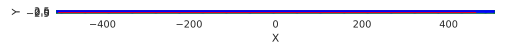

In [121]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
source_height = 0.5  # 与逆向设计中的meta_grarting区域保持一致
input_wvg_length = 5
output_wvg_length = 5
design_region_x = 1000
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)


####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.02 * fcen

# sources overlapped in x direction
# start_angle = 0
# stop_angle = 25
# sources = []
# angle_resolution = 1
# for ii in range(0, int(stop_angle / angle_resolution) + 1, 1):
#     angle = ii * angle_resolution
#     rot_angle = angle
#     k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
#     sources.append(
#         mp.EigenModeSource(
#             src=mp.GaussianSource(fcen, fwidth=fwidth),
#             center=mp.Vector3(y=0),
#             size=mp.Vector3(x=design_region_x),
#             direction=mp.NO_DIRECTION,
#             eig_kpoint=k_point,
#             eig_band=1,
#             eig_parity=mp.ODD_Z,
#             eig_match_freq=True,
#         )
#     )
#     print(k_point)
#     # the amplitude of source is e_field, the intensity is square of e_field
#     # the line amplitude means quadratic intensity
#     sources[ii].amplitude = int(stop_angle / angle_resolution) - ii

# source located at different position in x direction
start_angle = 0
stop_angle = 25
sources = []
angle_resolution = 0.01
separation_length = 0
focus_lengths = []
source_span = design_region_x / ((stop_angle - start_angle + 1) / angle_resolution)
phase_delays = []
phase_locals = []
for ii in range(0, int(stop_angle / angle_resolution) + 1, 1):
    angle = ii * angle_resolution
    rot_angle = angle
    k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
    source_x = (
        -design_region_x / 2
        - separation_length * ((stop_angle / angle_resolution) + 1) / 2
        + ii * (source_span + separation_length)
        + source_span / 2
    )
    # 如果source是等距分布，则其焦点不是同一个点
    focus_length = (
        ii * source_span / np.sin(np.radians(angle)) * np.sin(np.radians(90 - angle))
    )
    focus_lengths.append(focus_length)
    if ii == 0:
        phase_delay = 0
    else:
        phase_delay = (
            2
            * np.pi
            / wvl
            * (((ii * source_span) ** 2 + focus_length**2) ** 0.5 - focus_length)
        )
    phase_local = phase_delay % (2 * np.pi)
    phase_locals.append(phase_local)
    phase_delays.append(phase_delay)
    sources.append(
        mp.EigenModeSource(
            src=mp.ContinuousSource(fcen, fwidth=fwidth),
            center=mp.Vector3(x=source_x, y=0),
            size=mp.Vector3(x=source_span),
            direction=mp.NO_DIRECTION,
            eig_kpoint=k_point,
            eig_band=1,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
        )
    )
    print(k_point)
    # the amplitude of source is e_field, the intensity is square of e_field
    # the line amplitude means quadratic intensity
    # sources[ii].amplitude = np.exp(1j * phase_delay) * (
    #     int(stop_angle / angle_resolution) - ii
    # )
    # sources[ii].amplitude = np.exp(1j * phase_delay)
    sources[ii].amplitude = np.exp(1j * phase_local) * np.sqrt(
        int(stop_angle / angle_resolution) - ii
    )

# # single source
# sources = []
# angle = 5
# rot_angle = angle
# k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
# source_x = 0
# source_span = 10
# sources.append(
#     mp.EigenModeSource(
#         src=mp.ContinuousSource(fcen, fwidth=fwidth),
#         center=mp.Vector3(x=source_x, y=0),
#         size=mp.Vector3(x=source_span),
#         direction=mp.NO_DIRECTION,
#         eig_kpoint=k_point,
#         eig_band=1,
#         eig_parity=mp.ODD_Z,
#         eig_match_freq=True,
#     )
# )


####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
)

# ############### Monitor ###################
nfreq = 1
near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
)

field_monitor = sim.add_dft_fields(
    [mp.Ez],
    fcen,
    fwidth,
    nfreq,
    center=mp.Vector3(),
    size=mp.Vector3(sx, sy),
)
# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    nfreq,
    mp.Near2FarRegion(
        center=mp.Vector3(y=0.5 * (sy - 2 * dpml)),
        size=mp.Vector3(sx - 2 * dpml, 0),
        weight=1,
    ),
    # mp.Near2FarRegion(
    #     center=mp.Vector3(y=-0.5 * (sy - 2 * dpml)),
    #     size=mp.Vector3(sx - 2 * dpml, 0),
    #     weight=-1,
    # ),
    # mp.Near2FarRegion(
    #     center=mp.Vector3(x=0.5 * (sx - 2 * dpml)),
    #     size=mp.Vector3(0, sy - 2 * dpml),
    #     weight=1,
    # ),
    # mp.Near2FarRegion(
    #     center=mp.Vector3(x=-0.5 * (sx - 2 * dpml)),
    #     size=mp.Vector3(0, sy - 2 * dpml),
    #     weight=-1,
    # ),
)

# geometry plot
sim.plot2D()

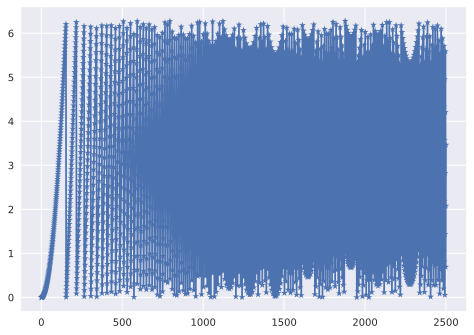

In [122]:
plt.plot(phase_locals, '-*')

FloatProgress(value=0.0, description='0% done ')

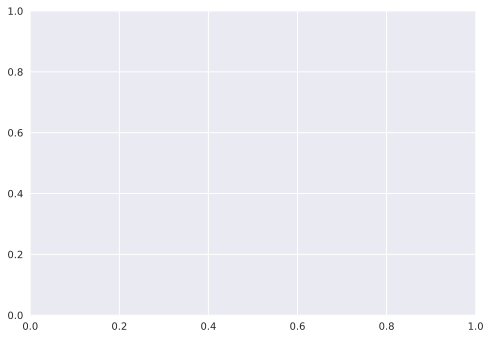

In [123]:
mpt = mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

# sim.run(
#     mp.at_every(1, Animate),
#     until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
# )
sim.run(
    # mp.at_every(1, Animate),
    until=100,
)

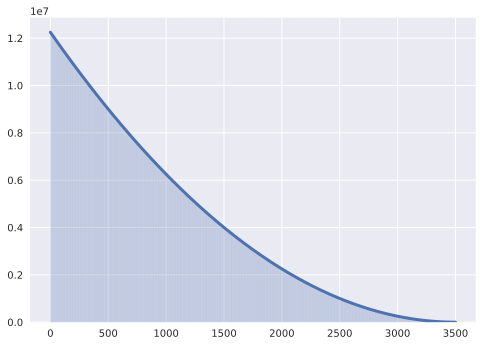

In [114]:
amplitudes = []
for source in sources:
    amplitudes.append(source.amplitude)
plt.bar(
    range(0, int(stop_angle / angle_resolution) + 1, 1),
    np.power(np.abs(np.array(amplitudes)), 2),
    width=0.3,
)
plt.plot(
    range(0, int(stop_angle / angle_resolution) + 1, 1),
    np.power(np.abs(np.array(amplitudes)), 2),
    linewidth=3,
)

In [126]:
Animate.to_jshtml(fps=1)

**DFT field** 

19118914.382310107


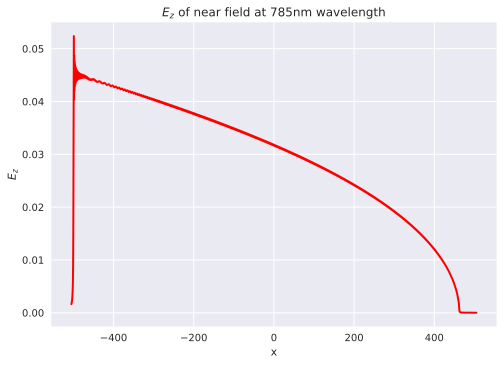

In [127]:
output_dft = sim.get_dft_array(near_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=near_dft)  # type: ignore
# normalize the output_dft
figure, ax = plt.subplots()
total_power = np.sum(np.abs(output_dft) ** 2 * (x[1] - x[0]))
print(total_power)
norm_output_dft = output_dft / np.sqrt(total_power)
# plt.plot(x, np.real(norm_output_dft), "-b")
# plt.plot(x, np.imag(norm_output_dft), "--r")
plt.plot(x, np.abs(norm_output_dft), "-r", linewidth=2)
plt.title(r"$ E_z $ of near field at 785nm wavelength")
ax.set_xlabel("x")
ax.set_ylabel(r"$ E_z $")
np.save(save_path + "near_field.npy", norm_output_dft)

In [8]:
# obj = max(sum(E*conj(E)))
# print(np.abs(np.sum(norm_output_dft * np.conj(norm_output_dft))))

In [46]:
print(np.sum(np.abs(norm_output_dft)**2*(x[1]-x[0])))

1.0


In [10]:
# input_mode = sim.get_eigenmode_coefficients(
#     near_field, list(range(1, 26, 1)), eig_parity=mp.EVEN_Y + mp.ODD_Z
# )
# input_mode_coe = np.squeeze(input_mode.alpha)
# input_flux = mp.get_fluxes(near_field)
# print(f"根据eigenmode_coe[0]计算得到的flux: {abs(input_mode_coe[0]) ** 2}")
# print(f"根据flux计算得到的flux: {input_flux}")
# print(f'逆向eigenmode_coe[0]: {abs(input_mode_coe[1]) ** 2}')
# print(f"逆向eigenmode_coe[1]: {abs(input_mode_coe[1]) ** 2}")

The angle of maximum intensity is 0.93517371965307


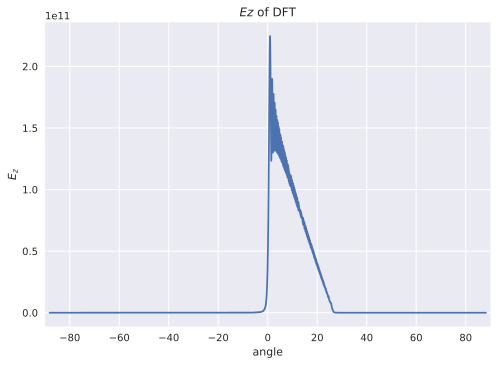

In [129]:
# dft ot near field
kx = np.fft.fftshift(np.fft.fftfreq(len(x), grid))
near_field_fft = np.fft.fftshift(np.fft.fft(output_dft))

k = 1 / wvl
kx[np.abs(kx) > k] = np.nan
angle = np.arcsin(kx / k) * 180 / np.pi

figure, ax = plt.subplots()
plt.plot(angle, np.abs(near_field_fft) ** 2, "-")
# plt.scatter(angle, near_field_fft)
plt.title(r"$ Ez $ of DFT")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
ax.set_xlim(-90, 90)

max_index = np.argmax(np.abs(near_field_fft) ** 2)
print(f"The angle of maximum intensity is {angle[max_index]}")


source.amplitude is 1, flux is 15.4

In [145]:
am = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(fcen)
print(np.abs(am))
print((1 / np.abs(am)) ** 2)  


0.025477707006369428
1540.5625


**Field monitor**

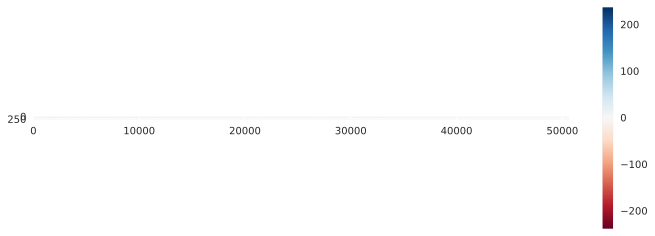

In [130]:
field_data = sim.get_dft_array(field_monitor, mp.Ez, 0)
field_eps = sim.get_array(
    component=mp.Permeability, center=mp.Vector3(), size=mp.Vector3(sx, sy)
)
[x, y, z, w] = sim.get_array_metadata(dft_cell=field_monitor)
x_grid, y_grid = np.meshgrid(x, y)
plt.figure(figsize=(12, 4))
# plt.pcolormesh(x_grid, y_grid, field_eps.transpose(), cmap="binary")
field_data = np.flipud(field_data.transpose())
# plt.imshow(np.angle(field_data[:][0:100])* np.abs(field_data[:][0:100]), cmap="RdBu")
# plot x and y axis
# plt.imshow(np.real(field_data[:]), cmap="RdBu", extent=[x[0], x[-1], y[0], y[-1]])
plt.imshow(np.real(field_data[:]), cmap="RdBu")
# plt.xticks([src_region.center.x, out_region.center.x])
# plt.yticks([0.5])
plt.colorbar()

<Axes: xlabel='X', ylabel='Y'>

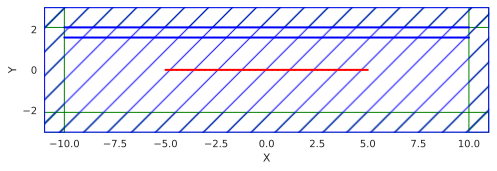

In [63]:
sim.plot2D()

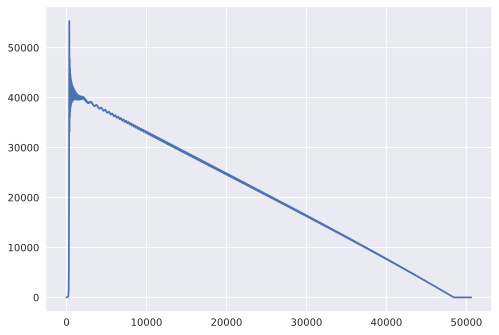

In [132]:
line=100
# plt.plot(np.real(field_data[:][line]))8
# plt.plot(np.imag(field_data[:][line]))
plt.plot(np.abs(field_data[:][line])**2)

**far field**

Output_angle of grating coupler: 0.9235792017862862 degree
max of far field: 110.39148818464076


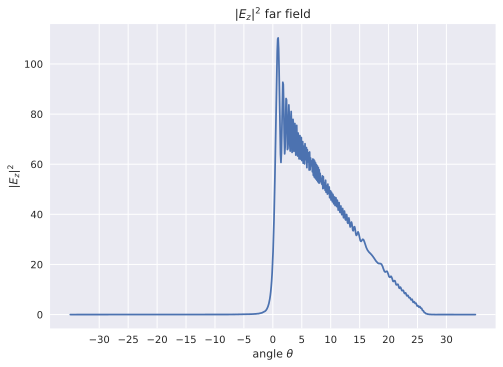

In [133]:
# anzhao1dianshu1
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 35  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

ff = sim.get_farfields(
    n2f_field,
    ff_res,
    center=mp.Vector3(0, ff_distance),
    size=mp.Vector3(x=2 * ff_length),
)
# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
# rel_enh = np.abs(ff["Ez"])
rel_enh = np.abs(ff["Ez"]) ** 2

figure, ax = plt.subplots()
plt.plot(angles, rel_enh, "-")
plt.title(r"$ {|E_z|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ {|E_z|}^2 $")
ax.set_xticks(range(-30, 35, 5))
index = np.argmax(rel_enh)
print(f"Output_angle of grating coupler: {angles[index]} degree")
print(f"max of far field: {np.max(rel_enh)}")

In [21]:
rel_enh

array([9.17792055e-05, 8.20790559e-05, 8.99896454e-05, 9.76619566e-05,
       8.72986872e-05, 8.94679662e-05, 1.01456121e-04, 9.34171953e-05,
       9.00099696e-05, 1.03765024e-04, 9.94300790e-05, 9.17447268e-05,
       1.05425566e-04, 1.04862121e-04, 9.43939060e-05, 1.07137808e-04,
       1.09672707e-04, 9.76006144e-05, 1.09375352e-04, 1.14053713e-04,
       1.01103609e-04, 1.12447493e-04, 1.18252833e-04, 1.04791714e-04,
       1.16597834e-04, 1.22449247e-04, 1.08717956e-04, 1.22065942e-04,
       1.26671256e-04, 1.13139702e-04, 1.29058239e-04, 1.30772688e-04,
       1.18597007e-04, 1.37591862e-04, 1.34537565e-04, 1.25948247e-04,
       1.47247299e-04, 1.37980977e-04, 1.36201268e-04, 1.57001059e-04,
       1.41786792e-04, 1.50022040e-04, 1.65394834e-04, 1.47632979e-04,
       1.66996895e-04, 1.71221134e-04, 1.58059178e-04, 1.84924573e-04,
       1.74775469e-04, 1.75433694e-04, 1.99742641e-04, 1.79409236e-04,
       1.99483851e-04, 2.07513955e-04, 1.91643334e-04, 2.24340007e-04,
      

计算总场power

In [21]:
total_power = mp.get_fluxes(near_field)
print(total_power)

[236146319014.19788]


In [138]:
# 验证在0-25度光源传播下，monitor的远场角度分布
# 设置角度的分辨率为 0.2degree
d_angle = 0.01
ff_distance = 1e8
ff_angle = 89
ff_number = int(2 / d_angle) * ff_angle + 1
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, ff_distance, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]

ob_list = [sim.get_farfield(n2f_field, ff_point) for ff_point in ff_points]
n2f_angle_Ez = [Ez[2] for Ez in ob_list]
rel_enh = np.abs(n2f_angle_Ez) ** 2
figure, ax = plt.subplots()
plt.plot(ff_angles, rel_enh, "-")
plt.title(r"$ {|Ez|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta$")
ax.set_ylabel(r"$ {|E_z|}^2 $")

KeyboardInterrupt: 

In [136]:
import scipy.io as scio

scio.savemat(
    "positive_angle_quadratic.mat", {"ff_angles": ff_angles, "rel_enh": rel_enh}
)

**验证far field计算得到的power与mp.get_fluxes()相等**

In [27]:
d_length = []
for angle in ff_angles:
    # The length of each angle in the far field
    length = ff_distance / np.cos(np.radians(angle))
    d_length.append(np.radians(d_angle) * length)

print(f"The total length {np.sum(d_length)} um calculated by angles")

energy = 0
for ii in range(0, ff_number, 1):
    energy = energy + d_length[ii] * (np.abs(n2f_angle_Ez[ii]) ** 2)
print(f"The power of near_field is {energy}")

near_field_flux = mp.get_fluxes(near_field)
print(f"The power of near_field is {near_field_flux[0]}")

The total length 9689347.824509013 um calculated by angles
The power of near_field is 236920552846.49902
The power of near_field is 236146319014.19788


**Normalized power: 1**

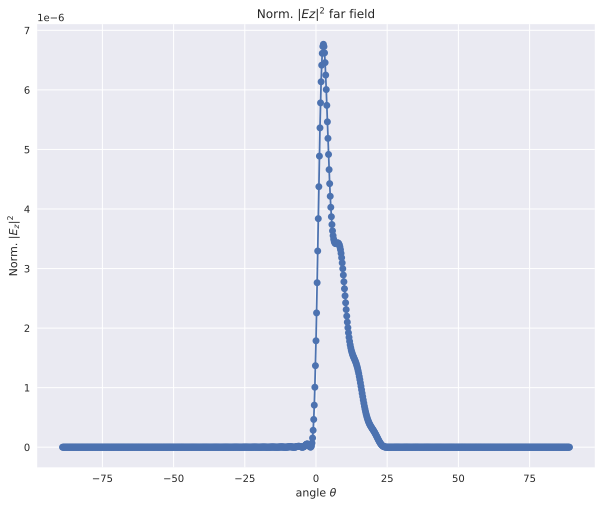

In [31]:
norm_rel = rel_enh / energy
figure, ax = plt.subplots(figsize=(10, 8))
plt.plot(ff_angles, norm_rel, "-o")
plt.title(r"Norm. $ {|Ez|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta$")
ax.set_ylabel(r"Norm. $ {|E_z|}^2 $")
np.save(save_path + "far_field.npy", norm_rel)


In [32]:
norm_rel.shape

(891,)

**验证归一化之后的enegy is 1**

In [33]:
norm_energy = 0
for ii in range(0, ff_number, 1):
    norm_energy = norm_energy + d_length[ii] * (norm_rel[ii])
print(f"The power of near_field is {norm_energy}")


The power of near_field is 0.9999999999999987


In [21]:
# norm_rel_load = np.load('norm_rel.npy')
# figure= plt.figure(figsize=(10, 10))
# plt.plot(ff_angles, norm_rel_load, "-o")


# forward (-25-0度)

当光栅周期较小时，会出现光栅的矢量大于波导的传播常数，会使得出射光束在负方向，因此考虑到最下化grating coupler的尺寸，尝试在负方向 (**-25-0度**) 远场分布


<Axes: xlabel='X', ylabel='Y'>

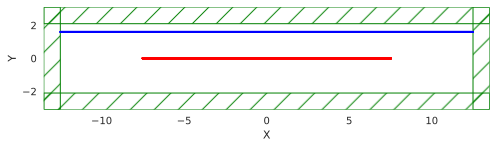

In [22]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
source_height = 0.5  # 与逆向设计中的meta_grarting区域保持一致
input_wvg_length = 5
output_wvg_length = 5
design_region_x = 15
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)


####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen

start_angle = 0
stop_angle = 25
sources = []
angle_resolution = 0.1
for ii in range(0, int(stop_angle / angle_resolution) + 1, 1):
    angle = ii * angle_resolution
    rot_angle = angle
    # 修改 k_point 角度从(0, 25) -> (0, -25)
    k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 + rot_angle))
    sources.append(
        mp.EigenModeSource(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            center=mp.Vector3(y=0),
            size=mp.Vector3(x=design_region_x),
            direction=mp.NO_DIRECTION,
            eig_kpoint=k_point,
            eig_band=1,
            eig_parity=mp.ODD_Z,
            eig_match_freq=True,
        )
    )
    # the amplitude of source is e_field, the intensity is square of e_field
    sources[ii].amplitude = np.sqrt(int(stop_angle / angle_resolution) - ii)

# angle = 5
# rot_angle = angle
# k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
# sources.append(
#     mp.EigenModeSource(
#         src=mp.GaussianSource(fcen, fwidth=fwidth),
#         center=mp.Vector3(y=0),
#         size=mp.Vector3(x=sx - 2 * dpml),
#         direction=mp.NO_DIRECTION,
#         eig_kpoint=k_point,
#         eig_band=1,
#         eig_parity=mp.ODD_Z,
#         eig_match_freq=True,
#     )
# )
# sources[0].amplitude = 2

# set nomrlized source: amplitude is 1 -> flux is 1
# sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
#     fcen
# )

####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
)

# ############### Monitor ###################
nfreq = 1


near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field = sim.add_mode_monitor(
    fcen,
    fwidth,
    nfreq,
    near_region,
)

near_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
)

# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    nfreq,
    near_region,
)

# geometry plot
sim.plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00032711 s
Working in 2D dimensions.
Computational cell is 27 x 6.2 x 0 with resolution 50


time for set_epsilon = 0.350218 s
-----------
MPB solved for frequency_1(7.8003e-17,1.27389,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.00222335,1.27388,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.00444669,1.27388,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.00667002,1.27387,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.00889333,1.27385,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0111166,1.27384,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0133399,1.27382,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0155631,1.27379,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0177862,1.27376,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0200093,1.27373,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0222324,1.27369,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0244553,1.27365,0) = 1.27389 after 97 iters
MPB solved for frequency_1(-0.0266782,1.27361,0) = 1.27389 aft

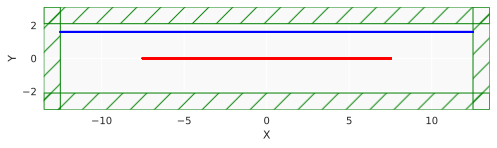

In [23]:
mpt = mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)

In [24]:
filename = "base_simulation_angle_source.mp4"
Animate.to_mp4(10, filename)

from IPython.core.display import Video

Video(filename)

Generating MP4...


14518329.313744918


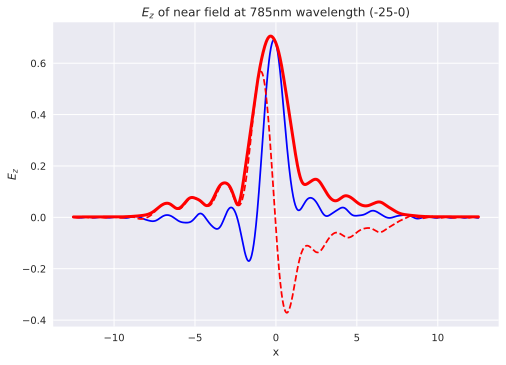

In [25]:
output_dft = sim.get_dft_array(near_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=near_dft)  # type: ignore
figure, ax = plt.subplots()
total_power = np.sum(np.abs(output_dft) ** 2 * (x[1] - x[0]))
print(total_power)
norm_output_dft = output_dft / np.sqrt(total_power)
plt.plot(x, np.real(norm_output_dft), "-b")
plt.plot(x, np.imag(norm_output_dft), "--r")
plt.plot(x, np.abs(norm_output_dft), "-r", linewidth=3)
plt.title(r"$ E_z $ of near field at 785nm wavelength (-25-0)")
ax.set_xlabel("x")
ax.set_ylabel(r"$ E_z $")
np.save("near_field.npy", norm_output_dft)

In [26]:
print(np.abs(np.sum(norm_output_dft * np.conj(norm_output_dft))))

50.000000000001066


Output_angle of grating coupler: -2.7462612353703135 degree
max of far field: 8.439743097320575


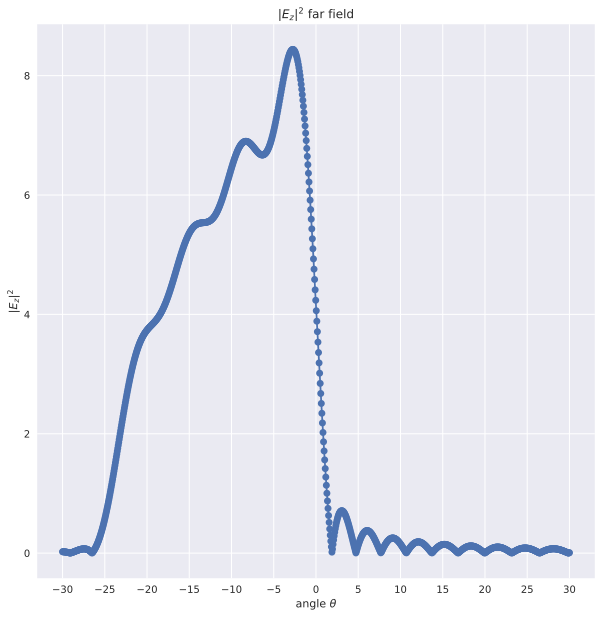

In [27]:
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 30  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

ff = sim.get_farfields(
    n2f_field,
    ff_res,
    center=mp.Vector3(0, ff_distance),
    size=mp.Vector3(x=2 * ff_length),
)
# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
rel_enh = np.abs(ff["Ez"])

figure, ax = plt.subplots(figsize=(10, 10))
plt.plot(angles, rel_enh, "-o")
plt.title(r"$ {|E_z|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ {|E_z|}^2 $")
ax.set_xticks(range(-30, 35, 5))
index = np.argmax(rel_enh)
print(f"Output_angle of grating coupler: {angles[index]} degree")
print(f"max of far field: {np.max(rel_enh)}")